In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.vision.learner import _add_norm

In [2]:
train_df = pd.read_csv('train1.csv')
train_df = train_df[~train_df['image_id'].isin(['1562043567.jpg', '3551135685.jpg', '2252529694.jpg'])]

In [3]:
path = Path('')

In [4]:
def get_x(r):
    return path/'train_images'/r['image_id']

def get_y(r):
    return r['label']

In [5]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=320, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=get_x,
                 get_y=get_y,
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(train_df, bs=bs)

In [6]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [7]:
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3,
                     init=nn.init.kaiming_normal_, custom_head=None, concat_pool=False, **kwargs):
    # disable concat pool for efficient net
    "Create custom architecture using `arch`, `n_in` and `n_out` from `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model  = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [8]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    # adding optimizer in
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [9]:
loss_func = LabelSmoothingCrossEntropy()
#cbs = MixUp

In [10]:
learn = timm_learner(dls, 'efficientnet_b3a', metrics= [accuracy], loss_func=loss_func, opt_func=ranger).to_native_fp16()

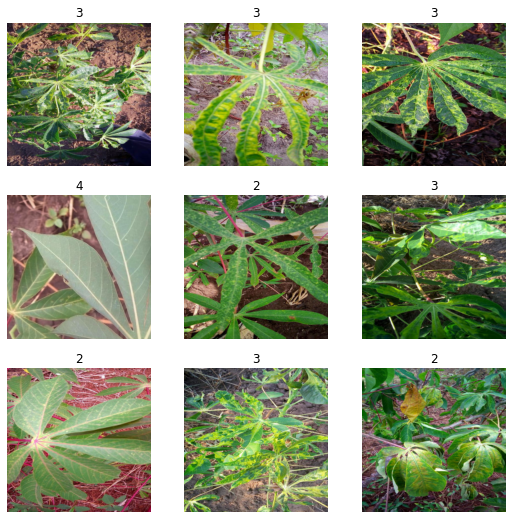

In [11]:
dls.show_batch()

In [ ]:
learn.lr_find()

In [12]:
cbs=[GradientAccumulation(), MixUp(), ReduceLROnPlateau(),
     EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, patience=4),
     SaveModelCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, fname='enet')
    ]

epoch     train_loss  valid_loss  accuracy  time    
0         0.957147    0.771330    0.822181  09:43     
Better model found at epoch 0 with accuracy value: 0.8221811652183533.
1         0.846450    0.719986    0.848983  09:45     
Better model found at epoch 1 with accuracy value: 0.8489833474159241.
2         0.809822    0.751670    0.857486  09:45     
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with accuracy value: 0.8574861288070679.
3         0.792262    0.707737    0.871349  09:45     
Better model found at epoch 3 with accuracy value: 0.8713493347167969.
4         0.773392    0.694358    0.860813  09:45     
5         0.776440    0.663303    0.874307  09:45     
Better model found at epoch 5 with accuracy value: 0.874306857585907.
6         0.763429    0.661047    0.876340  09:45     
Better model found at epoch 6 with accuracy value: 0.8763400912284851.
7         0.749262    0.661324    0.873013  09:45     
Epoch 7: reducing lr to 0.001
8         0.776955    

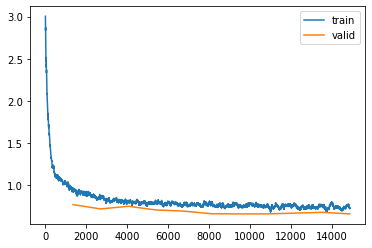

In [13]:
learn.fit_flat_cos(20,1e-2, cbs=cbs)
learn.recorder.plot_loss()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=1.0964781722577754e-06)

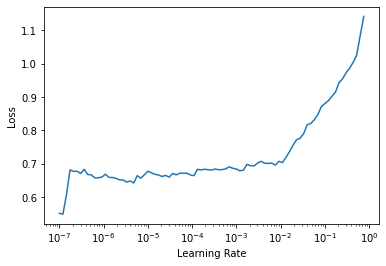

In [14]:
learn.unfreeze()
learn.lr_find()

In [15]:
cbs=[GradientAccumulation(), MixUp(), ReduceLROnPlateau(),
     EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, patience=4),
     SaveModelCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, fname='enet_unfreeze')
    ]

In [16]:
learn.fit_flat_cos(30, 1e-3, cbs=cbs)

epoch     train_loss  valid_loss  accuracy  time    
0         0.759404    0.660714    0.874492  13:34     
Better model found at epoch 0 with accuracy value: 0.8744916915893555.
1         0.785725    0.677243    0.871165  13:34     
Epoch 1: reducing lr to 0.0001
2         0.772139    0.680272    0.879298  13:34     
Epoch 2: reducing lr to 0.0001
Better model found at epoch 2 with accuracy value: 0.8792976140975952.
3         0.732903    0.644572    0.884104  13:35     
Better model found at epoch 3 with accuracy value: 0.884103536605835.
4         0.693793    0.645837    0.882994  13:35     
Epoch 4: reducing lr to 0.0001
5         0.681535    0.647958    0.883734  13:35     
Epoch 5: reducing lr to 0.0001
6         0.724406    0.651809    0.883549  13:35     
Epoch 6: reducing lr to 0.0001
7         0.695553    0.668859    0.878373  13:35     
Epoch 7: reducing lr to 0.0001
No improvement since epoch 3: early stopping


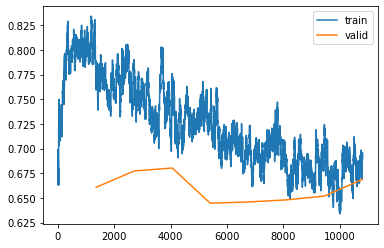

In [18]:
learn.recorder.plot_loss()

In [19]:
learn.load('enet_unfreeze')

/home/bf/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [20]:
train_df = pd.read_csv('train.csv')
train_df = train_df[~train_df['image_id'].isin(['1562043567.jpg', '3551135685.jpg', '2252529694.jpg'])]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=320, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=get_x,
                 get_y=get_y,
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(train_df, bs=bs)

In [22]:
learn.dls = dls

In [23]:
cbs=[GradientAccumulation(), MixUp(), ReduceLROnPlateau(),
     EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, patience=4),
     SaveModelCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, fname='enet_unfreeze_single')
    ]

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.3182567499825382e-06)

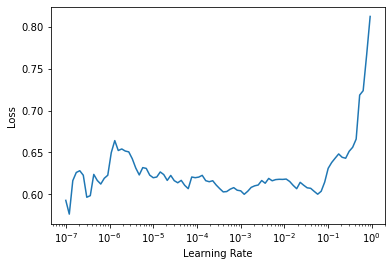

In [24]:
learn.freeze()
learn.lr_find()

In [25]:
learn.fit_flat_cos(30, slice(1e-4), cbs=cbs)

epoch     train_loss  valid_loss  accuracy  time    
0         0.698109    0.596667    0.904161  07:55     
Better model found at epoch 0 with accuracy value: 0.9041607975959778.
1         0.701111    0.596809    0.904395  07:56     
Epoch 1: reducing lr to 1e-05
Better model found at epoch 1 with accuracy value: 0.9043945670127869.
2         0.674437    0.596068    0.900888  07:57     
3         0.691257    0.599128    0.903226  07:56     
Epoch 3: reducing lr to 1e-05
4         0.693775    0.595475    0.905563  07:56     
Better model found at epoch 4 with accuracy value: 0.9055633544921875.
5         0.700553    0.594077    0.902525  07:57     
6         0.693921    0.597591    0.906031  07:57     
Epoch 6: reducing lr to 1e-05
Better model found at epoch 6 with accuracy value: 0.9060308337211609.
7         0.697787    0.601306    0.901823  07:57     
Epoch 7: reducing lr to 1e-05
8         0.703389    0.593862    0.906265  07:56     
Better model found at epoch 8 with accuracy valu

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=1.3182567499825382e-06)

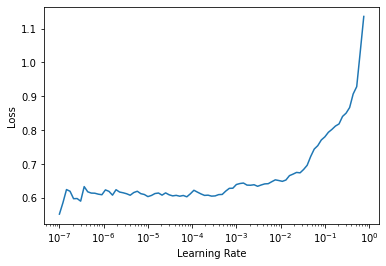

In [26]:
learn.unfreeze()
learn.lr_find()

In [27]:
cbs=[GradientAccumulation(), MixUp(), ReduceLROnPlateau(),
     EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, patience=4),
     SaveModelCallback(monitor='accuracy', comp=np.greater, min_delta=0.0001, fname='enet_unfreeze_single2')
    ]

In [28]:
learn.fit_flat_cos(30, slice(1e-6, 1e-4), cbs=cbs)

epoch     train_loss  valid_loss  accuracy  time    
0         0.692171    0.591562    0.906031  10:43     
Better model found at epoch 0 with accuracy value: 0.9060308337211609.
1         0.714920    0.592183    0.904862  10:43     
Epoch 1: reducing lr to 1e-05
2         0.683973    0.592911    0.908135  10:44     
Epoch 2: reducing lr to 1e-05
Better model found at epoch 2 with accuracy value: 0.9081346392631531.
3         0.675133    0.590015    0.905330  10:43     
4         0.680962    0.589814    0.905797  10:43     
5         0.690165    0.591375    0.902992  10:43     
Epoch 5: reducing lr to 1e-05
6         0.681698    0.591888    0.903226  10:43     
Epoch 6: reducing lr to 1e-05
No improvement since epoch 2: early stopping
